   # STOCK MARKET PREDICTION



## importing required python packages


In [1]:
import datetime as dt
import numpy as np
import pandas as pd
pd.core.common.is_list_like=pd.api.types.is_list_like
from pandas_datareader import DataReader


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import plotly.offline as pyo
from plotly.graph_objs import Figure, Data
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


import matplotlib.pyplot as plt   # Import matplotlib
import seaborn as sns  #seaborn library
# This line is necessary for the plot to appear in a Jupyter notebook
%matplotlib inline
# Control the default size of figures in this Jupyter notebook
# For Notebooks
pyo.offline.init_notebook_mode()
init_notebook_mode(connected=True)

## DATA PREPROCESSING

In [2]:
#get the current date and time
end=dt.datetime.now()
#start time 5 years
start=end-dt.timedelta(days=5*365)
#get the data for the MU for 5 years
df=DataReader("MU",'iex',start,end)
df.reset_index(inplace=True)
df.head()

5y


date   open    high    low   close    volume
0  2013-11-15  19.38  19.830  19.22  19.461  51592829
1  2013-11-18  19.58  19.880  19.09  19.290  47549892
2  2013-11-19  19.35  19.870  19.05  19.060  51853726
3  2013-11-20  19.19  19.220  18.51  18.800  44815768
4  2013-11-21  19.04  20.115  18.96  19.990  93347344

In [3]:

#plotting graph
trace = go.Candlestick(x=df.date,
                       open=df.open,
                       high=df.high,
                       low=df.low,
                       close=df.close,
                       increasing=dict(line=dict(color= '#17BECF')),
                       decreasing=dict(line=dict(color= '#7F7F7F')))
data = [trace]
pyo.iplot(data)




In [4]:
#plot a closing
trace = go.Scatter(x=df.date,
                       y=df.close,
                       
                       )
data = [trace]
pyo.iplot(data, filename='candlestick_datetime.html')



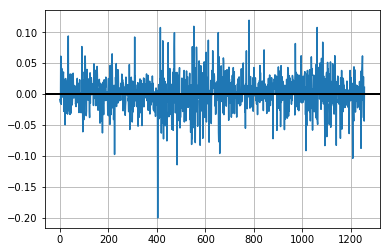

In [5]:
#calculate the changes between days log difference
df["loc_Ret"]=np.log(df["close"]/df["close"].shift(1))
#plot the changes between days
df["loc_Ret"].plot(grid = True).axhline(y = 0, color = "black", lw = 2)


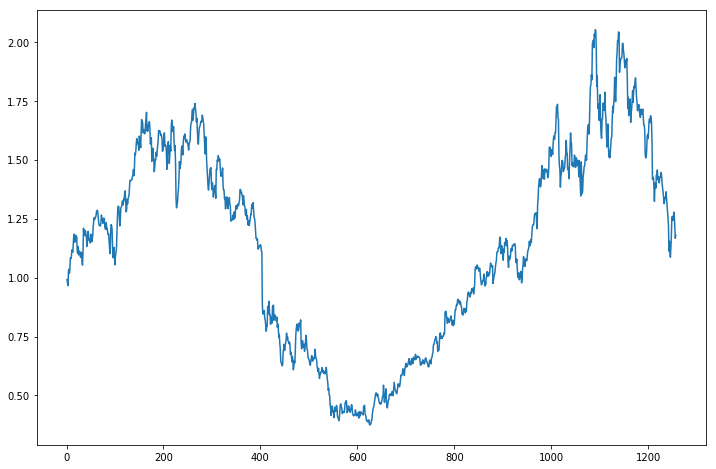

In [6]:
# Calculate the cumulative daily returns
cum_daily_return = (1 + df["loc_Ret"]).cumprod()
cum_daily_return.plot(figsize=(12,8))
plt.show()


max value: 0.119401420862
min value: -0.200300701933


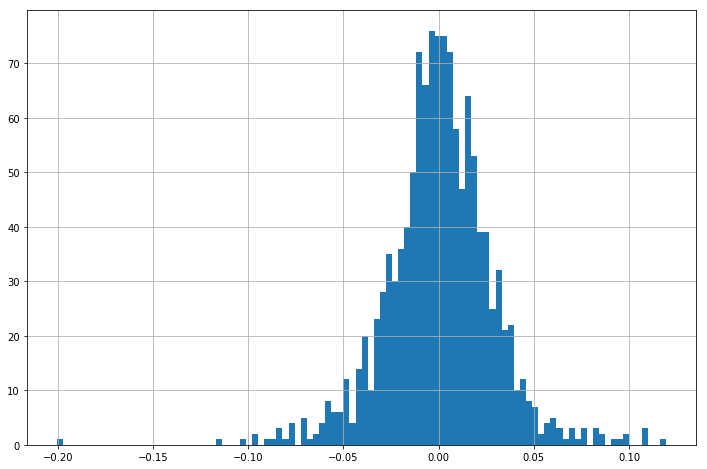

In [7]:
### feature based on quatnitle
df["crash"]=np.where(df["loc_Ret"]<df["loc_Ret"].quantile(0.25),1,0)
df["down"]=np.where((df["loc_Ret"]>df["loc_Ret"].quantile(0.25)) & (df["loc_Ret"]<=df["loc_Ret"].quantile(0.50)),1,0)
df["up"]=np.where((df["loc_Ret"]>df["loc_Ret"].quantile(0.50)) & (df["loc_Ret"]<=df["loc_Ret"].quantile(0.75)) ,1,0)
df["jump"]=np.where(df["loc_Ret"]>=df["loc_Ret"].quantile(0.75),1,0)
#printing a max and min value
print("max value:",df["loc_Ret"].max())
print("min value:",df["loc_Ret"].min())
df["loc_Ret"].hist(bins=100,figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11294f2e8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a2052c358>]], dtype=object)

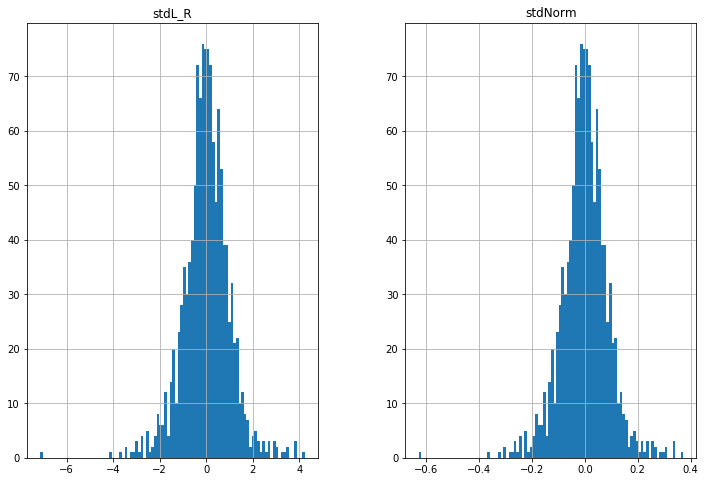

In [8]:
#standarization and Normalization
df["stdNorm"]=(df["loc_Ret"]-df["loc_Ret"].mean())/(df["loc_Ret"].max()-df["loc_Ret"].min())
df["stdL_R"]=(df["loc_Ret"]-df["loc_Ret"].mean())/(df["loc_Ret"].std())
#plotting a standarization and normalization
df[["stdL_R","stdNorm"]].hist(bins=100,figsize=(12,8))


In [9]:
#plotting moving average for MA3 and MA14 and MA21 for close price
from plotly.graph_objs import Figure, Data
p1 = go.Scatter(x=df.date, 
                y=df["close"].rolling(window=3).mean(), 
                mode="lines",
                marker=dict(color='red')
               )
p2 = go.Scatter(x=df.date, 
                y=df["close"].rolling(window=14).mean(),
                mode='lines',
                line=dict(color='blue', width=3)
                )
p3 = go.Scatter(x=df.date, 
                y=df["close"].rolling(window=21).mean(),
                mode='lines',
                line=dict(color='green', width=3)
                )
            
layout = go.Layout(xaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p1, p2,p3], layout=layout)


pyo.iplot(fig)





In [10]:
#plotting moving average for MA3 and MA7 for log return
from plotly.graph_objs import Figure, Data
p1 = go.Scatter(x=df.date, 
                y=df["loc_Ret"].rolling(window=3).mean(), 
                mode="lines",
                marker=dict(color='red')
               )
p2 = go.Scatter(x=df.date, 
                y=df["loc_Ret"].rolling(window=7).mean(),
                mode='lines',
                line=dict(color='blue', width=3)
                )

            
layout = go.Layout(xaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p1, p2], layout=layout)


pyo.iplot(fig)





In [11]:
df.head()


date   open    high    low   close    volume   loc_Ret  crash  down  \
0  2013-11-15  19.38  19.830  19.22  19.461  51592829       NaN      0     0   
1  2013-11-18  19.58  19.880  19.09  19.290  47549892 -0.008826      0     1   
2  2013-11-19  19.35  19.870  19.05  19.060  51853726 -0.011995      0     1   
3  2013-11-20  19.19  19.220  18.51  18.800  44815768 -0.013735      0     1   
4  2013-11-21  19.04  20.115  18.96  19.990  93347344  0.061375      0     0   

   up  jump   stdNorm    stdL_R  
0   0     0       NaN       NaN  
1   0     0 -0.029261 -0.332640  
2   0     0 -0.039174 -0.445334  
3   0     0 -0.044617 -0.507209  
4   0     1  0.190321  2.163568

## LINEAR REGRESSION

In [12]:
##feature selection
df["predition"]=df["close"].shift(-1)
X=np.array(df[["close"]])
X=X[:-1]
#droping a NAN value 
df["predition"].dropna(inplace=True)
y=np.array(df[["predition"]])
y=y[:-1]

#scaling the feature
scaler=StandardScaler().fit(y)
X=scaler.transform(X)
y=scaler.transform(y)


In [13]:
#splitting the X,y into training and test set
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211] TEST: [212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 

In [14]:
#linear regression
lr=LinearRegression()
#fitting a linear regression
lr.fit(X_train,y_train)
#confidence score 
confidence=lr.score(X_test,y_test)
#predicting a model 
predict=lr.predict(X_test)

In [15]:
print("confidence",confidence)

confidence 0.949824186958


In [16]:
#function to calculate MAPE
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [17]:

print(MAPE(y_test,predict))

6.1562306763


In [18]:
#coefficient of determination
coefficient_of_dermination = r2_score(y_test, predict)
print("coefficient of determination",coefficient_of_dermination)

coefficient of determination 0.949824186958


In [19]:
#function to plot a training and test set model
def data_to_plotly(x):
    k = []
    
    for i in range(0, len(x)):
        k.append(x[i][0])
        
    return k
#plotting a graph for the training set
p1 = go.Scatter(x=data_to_plotly(X_train), 
                y=data_to_plotly(y_train), 
                mode='markers',
                marker=dict(color='red')
               )
p2 = go.Scatter(x=data_to_plotly(X_train), 
                y=data_to_plotly(lr.predict(X_train)),
                mode='lines',
                line=dict(color='blue', width=3)
                )
layout = go.Layout(xaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p1, p2], layout=layout)


pyo.iplot(fig)

In [20]:
#plotting for a test set
p3 = go.Scatter(x=data_to_plotly(X_test), 
                y=data_to_plotly(y_test), 
                mode='markers',
                marker=dict(color='red')
               )
p4 = go.Scatter(x=data_to_plotly(X_train), 
                y=data_to_plotly(lr.predict(X_train)),
                mode='lines',
                line=dict(color='blue', width=3)
                )
layout = go.Layout(xaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   showlegend=False, hovermode='closest')

fig1 = go.Figure(data=[p3, p4], layout=layout)


pyo.iplot(fig1)


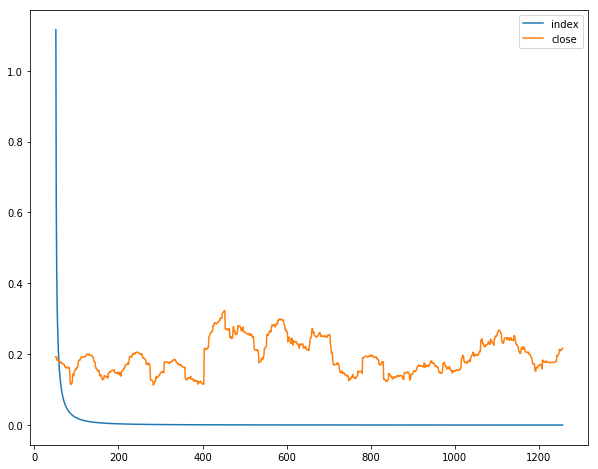

In [21]:
# vloatility calculation

# Define the minumum of periods to consider 
min_periods = 50

daily_close_px = df[['close']].reset_index()
# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

## TYPE 2 FEATURE

In [22]:
df["ASY_2"]=(df["close"]-df["close"].shift(1)).rolling(window=2).sum()/2
#create a  On-balance volume feature
for stock in range(len(df["close"])):
    new = (df['volume'] * (~df['close'].diff().le(0) * 2 -1)).cumsum()
    df['OBV'] = new



In [23]:
df.head()

date   open    high    low   close    volume   loc_Ret  crash  down  \
0  2013-11-15  19.38  19.830  19.22  19.461  51592829       NaN      0     0   
1  2013-11-18  19.58  19.880  19.09  19.290  47549892 -0.008826      0     1   
2  2013-11-19  19.35  19.870  19.05  19.060  51853726 -0.011995      0     1   
3  2013-11-20  19.19  19.220  18.51  18.800  44815768 -0.013735      0     1   
4  2013-11-21  19.04  20.115  18.96  19.990  93347344  0.061375      0     0   

   up  jump   stdNorm    stdL_R  predition   ASY_2       OBV  
0   0     0       NaN       NaN      19.29     NaN  51592829  
1   0     0 -0.029261 -0.332640      19.06     NaN   4042937  
2   0     0 -0.039174 -0.445334      18.80 -0.2005 -47810789  
3   0     0 -0.044617 -0.507209      19.99 -0.2450 -92626557  
4   0     1  0.190321  2.163568      20.19  0.4650    720787

In [24]:
#dropping all the NAN rows
df=df.dropna(axis="rows")
df.head()

date   open    high      low  close    volume   loc_Ret  crash  down  \
2  2013-11-19  19.35  19.870  19.0500  19.06  51853726 -0.011995      0     1   
3  2013-11-20  19.19  19.220  18.5100  18.80  44815768 -0.013735      0     1   
4  2013-11-21  19.04  20.115  18.9600  19.99  93347344  0.061375      0     0   
5  2013-11-22  19.91  20.320  19.6600  20.19  40144827  0.009955      0     0   
6  2013-11-25  20.44  20.500  19.7104  19.86  33875466 -0.016480      1     0   

   up  jump   stdNorm    stdL_R  predition   ASY_2       OBV  
2   0     0 -0.039174 -0.445334      18.80 -0.2005 -47810789  
3   0     0 -0.044617 -0.507209      19.99 -0.2450 -92626557  
4   0     1  0.190321  2.163568      20.19  0.4650    720787  
5   1     0  0.029484  0.335173      19.86  0.6950  40865614  
6   0     0 -0.053203 -0.604806      20.31 -0.0650   6990148

## PERFORMING A LOGISTIC REGRESSION

In [25]:
# feature showing the signal on the basis of closing price
df["signal"]=np.where(df["close"].shift(-1)>df["close"],1,-1)
df["buy/sell"]=np.where(df["signal"]==1,"buy","sell")

In [26]:
df.head(20)


date   open     high      low   close    volume   loc_Ret  crash  \
2   2013-11-19  19.35  19.8700  19.0500  19.060  51853726 -0.011995      0   
3   2013-11-20  19.19  19.2200  18.5100  18.800  44815768 -0.013735      0   
4   2013-11-21  19.04  20.1150  18.9600  19.990  93347344  0.061375      0   
5   2013-11-22  19.91  20.3200  19.6600  20.190  40144827  0.009955      0   
6   2013-11-25  20.44  20.5000  19.7104  19.860  33875466 -0.016480      1   
7   2013-11-26  19.93  20.4100  19.8300  20.310  33585049  0.022406      0   
8   2013-11-27  20.41  21.1900  20.2900  21.170  40572662  0.041472      0   
9   2013-11-29  21.30  21.3100  20.9000  21.100  20081775 -0.003312      0   
10  2013-12-02  21.10  21.6400  20.9600  21.270  34102762  0.008025      0   
11  2013-12-03  21.44  21.9000  21.3300  21.830  43553080  0.025988      0   
12  2013-12-04  21.79  21.9300  21.4100  21.759  34609036 -0.003258      0   
13  2013-12-05  21.86  22.0900  21.5900  21.650  30302830 -0.005022      0   
14  2013-12-06  21.97  22.3100  21.8000  22.310  32237775  0.030030      0   
15  2013-12-09  22.66  23.6700  22.6000  23.120  65756702  0.035663      0   
16  2013-12-10  23.12  23.4385  22.8000  23.140  41919491  0.000865      0   
17  2013-12-11  22.47  22.9100  22.2900  22.500  52447475 -0.028047      1   
18  2013-12-12  22.68  23.0900  22.3550  22.540  52600226  0.001776      0   
19  2013-12-13  22.73  23.2000  22.6500  23.080  31018671  0.023675      0   
20  2013-12-16  23.17  23.4200  22.6600  22.770  35065801 -0.013523      0   
21  2013-12-17  22.85  22.9800  22.5500  22.920  26694932  0.006566      0   

    down  up  jump   stdNorm    stdL_R  predition   ASY_2        OBV  signal  \
2      1   0     0 -0.039174 -0.445334     18.800 -0.2005  -47810789      -1   
3      1   0     0 -0.044617 -0.507209     19.990 -0.2450  -92626557       1   
4      0   0     1  0.190321  2.163568     20.190  0.4650     720787       1   
5      0   1     0  0.029484  0.335173     19.860  0.6950   40865614      -1   
6      0   0     0 -0.053203 -0.604806     20.310 -0.0650    6990148       1   
7      0   0     1  0.068428  0.777886     21.170  0.0600   40575197       1   
8      0   0     1  0.128065  1.455835     21.100  0.6550   81147859      -1   
9      1   0     0 -0.012015 -0.136588     21.270  0.3950   61066084       1   
10     0   1     0  0.023445  0.266521     21.830  0.0500   95168846       1   
11     0   0     1  0.079631  0.905249     21.759  0.3650  138721926      -1   
12     1   0     0 -0.011845 -0.134655     21.650  0.2445  104112890      -1   
13     1   0     0 -0.017364 -0.197391     22.310 -0.0900   73810060       1   
14     0   0     1  0.092274  1.048975     23.120  0.2755  106047835       1   
15     0   0     1  0.109895  1.249290     23.140  0.7350  171804537       1   
16     0   1     0  0.001049  0.011929     22.500  0.4150  213724028      -1   
17     0   0     0 -0.089385 -1.016129     22.540 -0.3100  161276553       1   
18     0   1     0  0.003900  0.044340     23.080 -0.3000  213876779       1   
19     0   0     1  0.072398  0.823017     22.770  0.2900  244895450      -1   
20     1   0     0 -0.043953 -0.499654     22.920  0.1150  209829649       1   
21     0   1     0  0.018883  0.214657     21.810 -0.0800  236524581      -1   

   buy/sell  
2      sell  
3       buy  
4       buy  
5      sell  
6       buy  
7       buy  
8      sell  
9       buy  
10      buy  
11     sell  
12     sell  
13      buy  
14      buy  
15      buy  
16     sell  
17      buy  
18      buy  
19     sell  
20      buy  
21     sell

In [27]:
##create a feature for a logistic regression
X1=df[["close","ASY_2","OBV"]].values
Y1=np.where(df["close"].shift(-1)>df["close"],1,-1)

In [28]:
#feature scaling
scaler=StandardScaler()
X1=scaler.fit_transform(X1)


In [29]:
# Encoding the Dependent Variable
labelencoder_y = LabelEncoder()
Y1 = labelencoder_y.fit_transform(Y1)

In [30]:
#splitting the X,y into training and test set
from sklearn.model_selection import TimeSeriesSplit
tscv1 = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv1.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train1, X_test1 = X1[train_index], X1[test_index]
    Y_train1, Y_test1 = Y1[train_index], Y1[test_index]



TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209] TEST: [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 

In [31]:
model = LogisticRegression()
model = model.fit (X_train1,Y_train1)
probability = model.predict_proba(X_test1)
predicted = model.predict(X_test1)


In [32]:
print (metrics.confusion_matrix(Y_test1, predicted))
print (metrics.classification_report(Y_test1, predicted))
print (model.score(X_test1,Y_test1))

[[60 45]
 [54 50]]
             precision    recall  f1-score   support

          0       0.53      0.57      0.55       105
          1       0.53      0.48      0.50       104

avg / total       0.53      0.53      0.53       209

0.526315789474


In [33]:
cross_val = cross_val_score(LogisticRegression(), X1, Y1, scoring='accuracy', cv=10)
print( cross_val)


[ 0.57480315  0.51968504  0.51587302  0.576       0.552       0.528       0.512
  0.512       0.512       0.56      ]


In [34]:
print( cross_val.mean())

0.536236120485


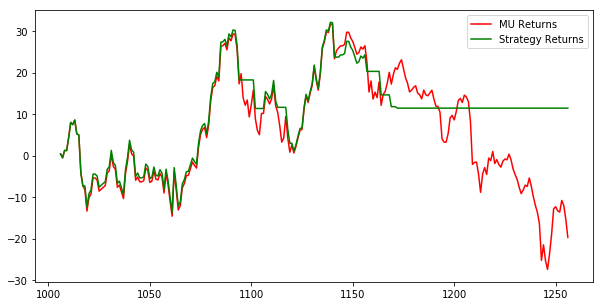

In [35]:
split = int(0.8*len(df))
#predicted signal
df['Predicted_Signal'] = model.predict(X1)
#Cumulative MU returns
df['MU_returns'] = np.log(df['close']/df['close'].shift(1))
Cumulative_MU_returns = df[split:]['MU_returns'].cumsum()*100
#cumulative strategy returns
df['Startegy_returns'] = df['MU_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = df[split:]['Startegy_returns'].cumsum()*100
#plot a graph
plt.figure(figsize=(10,5))
plt.plot(Cumulative_MU_returns, color='r',label = 'MU Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [36]:

#calculate the sharpe ratio
std=Cumulative_Strategy_returns.std()
sharpe=(Cumulative_Strategy_returns-Cumulative_MU_returns)/std
sharpe=sharpe.mean()
print("shape ratio: %.2f"%sharpe)

shape ratio: 0.40


In [37]:
def manually_calculate_tp_tn_fp_fn(test_y, test_predictions):
    """Manually create confusion matrix by comparing predictions with answers."""
    TP = 0
    TN = 0
    FP = 0
    FN = 0

    x = 0
    while x < len(test_y):
        if test_y[x] == 0 and test_predictions[x] == 0:
            TN += 1
        if test_y[x] == 0 and test_predictions[x] == 1:
            FP += 1
        if test_y[x] == 1 and test_predictions[x] == 1:
            TP += 1
        if test_y[x] == 1 and test_predictions[x] == 0:
            FN += 1
        x += 1

    cm = [[TN, FP],[FN, TP]]
    accuracy=(TP+TN)/x
    TPR=(TP/(TP+FN))
    precision=TP/(TP+FP)
    print(TP+TN,"total hits  out of ",x)
    print("Accuracy",accuracy)
    print("TPR",TPR)
    print("precision",precision)
    return cm

In [38]:
y_test=Y_test1.tolist()
pred=predicted.tolist()
manual = manually_calculate_tp_tn_fp_fn(y_test,pred)
print("confusion_matrix", manual)

110 total hits  out of  209
Accuracy 0.5263157894736842
TPR 0.4807692307692308
precision 0.5263157894736842
confusion_matrix [[60, 45], [54, 50]]


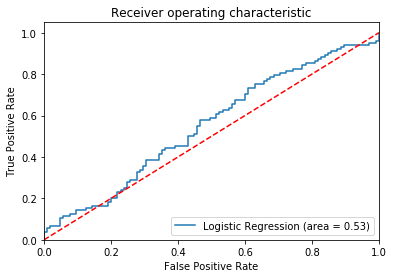

In [39]:
logit_roc_auc = roc_auc_score(Y_test1, model.predict(X_test1))
fpr, tpr, thresholds = roc_curve(Y_test1, model.predict_proba(X_test1)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()



Text(0.5,257.44,'Predicted label')

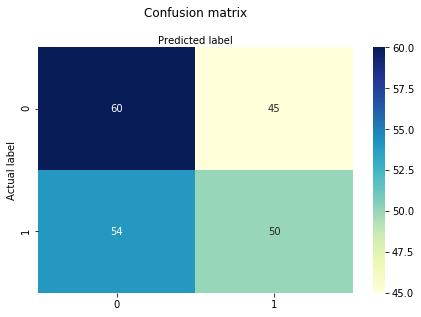

In [40]:
cnf_matrix0 = metrics.confusion_matrix(Y_test1, predicted)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix0), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')




## PREDICTING A STOCK MARKET CHANGE WITH A MOVING AVERAGE

In [41]:
# Initialize the short and long windows
short_window = 40
long_window = 240
# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
# Create short simple moving average over the short window
signals['short_mavg'] = df['close'].rolling(window=short_window, min_periods=1, center=False).mean()
# Create long simple moving average over the long window
signals['long_mavg'] = df['close'].rolling(window=long_window, min_periods=1, center=False).mean()
# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:]                                             > signals['long_mavg'][short_window:], 1.0, 0.0)   
# Generate trading orders
signals['positions'] = signals['signal'].diff()


signals.tail(20)


signal  short_mavg  long_mavg  positions
1237     0.0    46.02800  49.360708        0.0
1238     0.0    45.83825  49.352417        0.0
1239     0.0    45.61475  49.342375        0.0
1240     0.0    45.38350  49.330708        0.0
1241     0.0    45.11000  49.313250        0.0
1242     0.0    44.77525  49.290708        0.0
1243     0.0    44.35250  49.257083        0.0
1244     0.0    43.97625  49.223750        0.0
1245     0.0    43.54225  49.181250        0.0
1246     0.0    43.09575  49.134833        0.0
1247     0.0    42.69775  49.095875        0.0
1248     0.0    42.40225  49.060625        0.0
1249     0.0    42.28900  49.035458        0.0
1250     0.0    42.17550  49.004958        0.0
1251     0.0    42.05100  48.965458        0.0
1252     0.0    41.95600  48.926542        0.0
1253     0.0    41.93575  48.890083        0.0
1254     0.0    41.85625  48.858375        0.0
1255     0.0    41.72650  48.821625        0.0
1256     0.0    41.57300  48.795375        0.0

In [42]:
p1=go.Scatter(x=df.index, 
                y= df["close"], 
                name="closing_price",
                mode="lines",
                marker=dict(color='blue')
               )
p0=go.Scatter(x=df.index, 
                y= signals["short_mavg"], 
                name="short_mavg",
                mode="lines",
                marker=dict(color='red')
               )
p = go.Scatter(x=df.index, 
                y= signals["long_mavg"], 
                name="long_mavg",
                mode="lines",
                marker=dict(color='green')
               )
p2 = go.Scatter(x=signals.loc[signals.positions == 1.0].index, 
                y= signals.short_mavg[signals.positions == 1.0], 
               name="buy_signal",
                mode="markers",
                 marker = dict(
        size = 20,
        color = 'rgba(152, 0, 0, .8)',
        line = dict(
            width = 2,
            color = 'rgb(0, 0, 0)'
        )
    )
               )

p3 = go.Scatter(x=signals.loc[signals.positions == -1.0].index, 
                y= signals.short_mavg[signals.positions == -1.0], 
                name="sell_signal",
                mode="markers",
                marker = dict(
        size = 20,
        color = 'rgba(255, 182, 193, .9)',
        line = dict(
            width = 2,
        )
    )
               )


            
layout = go.Layout(xaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   yaxis=dict(ticks='', showticklabels=False,
                              zeroline=False),
                   showlegend=False, hovermode='closest')

fig = go.Figure(data=[p0,p,p1,p2,p3], layout=layout)


pyo.iplot(fig)

In [55]:
signals["close"]=df["close"]
signals["ASY_2"]=df["ASY_2"]
signals["OBV"]=df["OBV"]

X1=signals[["close","ASY_2","OBV"]].values
Y1=signals["signal"].values

In [56]:
signals.tail(20)

signal  short_mavg  long_mavg  positions  close  ASY_2        OBV
1237     0.0    46.02800  49.360708        0.0  43.21  0.370  956526771
1238     0.0    45.83825  49.352417        0.0  42.35  0.005  928767808
1239     0.0    45.61475  49.342375        0.0  41.30 -0.955  895206986
1240     0.0    45.38350  49.330708        0.0  40.45 -0.950  866565611
1241     0.0    45.11000  49.313250        0.0  39.76 -0.770  832124390
1242     0.0    44.77525  49.290708        0.0  38.68 -0.885  785760216
1243     0.0    44.35250  49.257083        0.0  35.43 -2.165  732663766
1244     0.0    43.97625  49.223750        0.0  36.78 -0.950  772289465
1245     0.0    43.54225  49.181250        0.0  35.40 -0.015  731032108
1246     0.0    43.09575  49.134833        0.0  34.66 -1.060  696855685
1247     0.0    42.69775  49.095875        0.0  36.01  0.305  732175182
1248     0.0    42.40225  49.060625        0.0  37.72  1.530  776230552
1249     0.0    42.28900  49.035458        0.0  40.12  2.055  820211962
1250     0.0    42.17550  49.004958        0.0  40.32  1.300  853857703
1251     0.0    42.05100  48.965458        0.0  39.92 -0.100  830953731
1252     0.0    41.95600  48.926542        0.0  39.80 -0.260  811637177
1253     0.0    41.93575  48.890083        0.0  40.93  0.505  834594398
1254     0.0    41.85625  48.858375        0.0  40.44  0.320  818985090
1255     0.0    41.72650  48.821625        0.0  39.11 -0.910  792882304
1256     0.0    41.57300  48.795375        0.0  37.44 -1.500  768059913

In [57]:

#splitting the X,y into training and test set
from sklearn.model_selection import TimeSeriesSplit
tscv2 = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv2.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train2, X_test2 = X1[train_index], X1[test_index]
    Y_train2, Y_test2 = Y1[train_index], Y1[test_index]
#feature scaling
sc=StandardScaler()
X_train2=sc.fit_transform(X_train2)
X_test2=sc.fit_transform(X_test2)


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209] TEST: [210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 

In [58]:

model1 = LogisticRegression()
model1 = model1.fit (X_train2,Y_train2)
probability1 = model1.predict_proba(X_test2)
predicted1 = model1.predict(X_test2)

print (metrics.confusion_matrix(Y_test2, predicted1))
print (metrics.classification_report(Y_test2, predicted1))
print (model.score(X_test2,Y_test2))
cross_val1 = cross_val_score(LogisticRegression(), X1, Y1, scoring='accuracy', cv=10)

print( cross_val1)
print( cross_val.mean())



[[ 36   0]
 [ 22 151]]
             precision    recall  f1-score   support

        0.0       0.62      1.00      0.77        36
        1.0       1.00      0.87      0.93       173

avg / total       0.93      0.89      0.90       209

0.684210526316
[ 0.35714286  0.61904762  0.84126984  0.63492063  0.34920635  0.48        0.68
  1.          1.          0.712     ]
0.536236120485


In [59]:


y_test1=Y_test2.tolist()
pred1=predicted1.tolist()
manual = manually_calculate_tp_tn_fp_fn(y_test1,pred1)
print("confusion_matrix", manual)


187 total hits  out of  209
Accuracy 0.8947368421052632
TPR 0.8728323699421965
precision 1.0
confusion_matrix [[36, 0], [22, 151]]


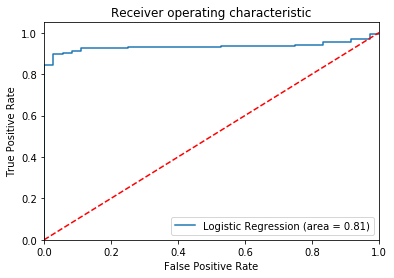

In [60]:

logit_roc_auc = roc_auc_score(Y_test2, model.predict(X_test2))
fpr, tpr, thresholds = roc_curve(Y_test2, model.predict_proba(X_test2)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()



Text(0.5,257.44,'Predicted label')

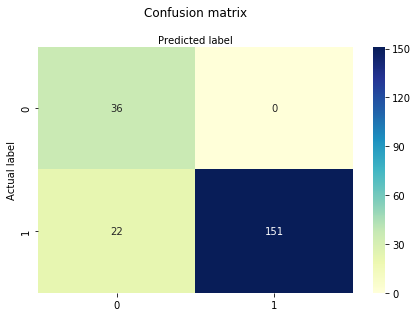

In [61]:
cnf_matrix = metrics.confusion_matrix(Y_test2, predicted1)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')



In [ ]:
h=.02
x_set=X_test2
y_set=Y_train2
x_min, x_max = x_set[:, 0].min() - .5, x_set[:, 0].max() + .5
y_min, y_max = x_set[:, 1].min() - .5, x_set[:, 1].max() + .5
y_min, y_max = x_set[:, 2].min() - .5, x_set[:, 2].max() + .5
x_ = np.arange(x_min, x_max, h)
y_ = np.arange(y_min, y_max, h)
z_ = np.arange(y_min, y_max, h)
xx, yy,zz = np.meshgrid(x_, y_,z_)


Z = model.predict(np.c_[xx.ravel(), yy.ravel(),zz.ravel()])
# Visualising the Test set results
def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale
from matplotlib import cm

cmap = matplotlib_to_plotly(plt.cm.Paired, 4)
Z = Z.reshape(xx.shape)

trace = go.Heatmap(x=x_, y=y_, z=Z,
                   colorscale=cmap,
                   showscale=False,
                  )
trace1 = go.Scatter(x=X_train1[:, 0], y=X_train1[:, 1],
                    mode='markers',
                    marker=dict(color=X_train1[:, 0],
                                colorscale=cmap,
                                showscale=False,
                                line=dict(color='black', width=1))
                   )


                   
fig = go.Figure(data=[trace, trace1])    
pyo.iplot(fig)